<a href="https://colab.research.google.com/github/vardanagarwal/crowd_counting/blob/master/dccnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
!pip install tensorflow-gpu==2.1.0 

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import zipfile
zf = zipfile.ZipFile('/content/drive/My Drive/ShanghaiTech_Crowd_Counting_Dataset.zip', "r")
zf.extractall()

In [0]:
import glob
import os
import numpy as np
from PIL import Image
import h5py
import cv2
import matplotlib.pyplot as plt
from matplotlib import cm as c
import tensorflow as tf
from keras import backend as K
from sklearn.metrics import mean_absolute_error, mean_squared_error
from google.colab import files

Using TensorFlow backend.


In [0]:
part_A_train = os.path.join('part_A_final/train_data','images')
part_A_test = os.path.join('part_A_final/test_data','images')
path_sets = [part_A_train]
path_train = [part_A_test]

img_paths = []
for path in path_sets:
    for img_path in glob.glob(os.path.join(path, '*.jpg')):
        img_paths.append(str(img_path))
TRAIN_LEN = len(img_paths)
print("Total train images : ",TRAIN_LEN)

test_paths = []
for path in path_train:
    for test_path in glob.glob(os.path.join(path, '*.jpg')):
        test_paths.append(str(test_path))
TEST_LEN = len(test_paths)
print("Total test images : ",TEST_LEN)

Total train images :  300
Total test images :  182


In [0]:
def create_img(path):
    #Function to load,normalize and return image 
    im = Image.open(path).convert('RGB')
    im = np.array(im)
    im = im/255.0
    im[:, :, 0]=(im[:, :, 0]-0.485)/0.229
    im[:, :, 1]=(im[:, :, 1]-0.456)/0.224
    im[:, :, 2]=(im[:, :, 2]-0.406)/0.225
    return im

def get_input(path):
    path = path[0] 
    img = create_img(path)
    return(img)    
    
def get_output(path):
    gt_file = h5py.File(path, 'r')   
    img = np.asarray(gt_file['density'])
    img = cv2.resize(img, (int(img.shape[1]/4), int(img.shape[0]/4)), interpolation=cv2.INTER_CUBIC)*16
    img = np.expand_dims(img, axis=3)
    return img

In [0]:
def image_generator(files, batch_size = 1):
    while True:
        input_path = np.random.choice(a = files, size = batch_size)
        batch_input = []
        batch_output = [] 
        
        #for input_path in batch_paths:
        inputt = get_input(input_path )
        output_path = os.path.join('/content/drive/My Drive/ShanghaiTech_h5', input_path[0].replace('.jpg','.h5').replace('images','ground'))
        output = get_output(output_path)
        batch_input += [inputt]
        batch_output += [output]

        batch_x = np.array( batch_input )
        batch_y = np.array( batch_output )
        
        yield( batch_x, batch_y )

In [0]:
EPOCHS = 50
BATCH_SIZE = 2
STEPS_PER_EPOCH = TRAIN_LEN//BATCH_SIZE
VALIDATION_STEPS = TEST_LEN//BATCH_SIZE//2
train_gen = image_generator(img_paths, BATCH_SIZE)
test_gen = image_generator(test_paths, BATCH_SIZE)

In [0]:
def branch_1_and_2(no_of_filters, layer, downscale=False):
  layer = tf.keras.layers.Conv2D(no_of_filters, (1, 1), padding='same', activation='relu')(layer)
  layer1 = tf.keras.layers.Conv2D(no_of_filters, (1, 5), padding='same', activation='relu')(layer)
  layer1 = tf.keras.layers.Conv2D(no_of_filters, (5, 1), padding='same', activation='relu')(layer1)
  layer2 = tf.keras.layers.Conv2D(no_of_filters, (5, 1), padding='same', activation='relu')(layer)
  layer2 = tf.keras.layers.Conv2D(no_of_filters, (1, 5), padding='same', activation='relu')(layer2)
  layer = tf.keras.layers.concatenate([layer1, layer2], axis = 3)
  if downscale == True:
    no_of_filters = no_of_filters//2
  else:
    no_of_filters = no_of_filters*2
  layer1 = tf.keras.layers.SeparableConv2D(no_of_filters, (3, 3), padding='same', dilation_rate=(1, 1), activation='relu')(layer)
  layer1 = tf.keras.layers.SeparableConv2D(no_of_filters, (3, 3), padding='same', dilation_rate=(1, 1), activation='relu')(layer1)
  layer2 = tf.keras.layers.SeparableConv2D(no_of_filters, (3, 3), padding='same', dilation_rate=(2, 2), activation='relu')(layer)
  layer2 = tf.keras.layers.SeparableConv2D(no_of_filters, (3, 3), padding='same', dilation_rate=(2, 2), activation='relu')(layer2)
  layer3 = tf.keras.layers.SeparableConv2D(no_of_filters, (3, 3), padding='same', dilation_rate=(3, 3), activation='relu')(layer)
  layer3 = tf.keras.layers.SeparableConv2D(no_of_filters, (3, 3), padding='same', dilation_rate=(3, 3), activation='relu')(layer3)
  layer = tf.keras.layers.concatenate([layer1, layer2, layer3], axis = 3)
  layer = tf.keras.layers.MaxPooling2D((2, 2))(layer)  
  return layer

def branch_3(no_of_filters, layer, downscale=False, batchNormlize = False):
  layer = tf.keras.layers.Conv2D(no_of_filters, (1, 1), padding='same', activation='relu')(layer)
  layer1 = tf.keras.layers.Conv2D(no_of_filters, (1, 3), padding='same', activation='relu')(layer)
  layer1 = tf.keras.layers.Conv2D(no_of_filters, (3, 1), padding='same', activation='relu')(layer1)
  layer2 = tf.keras.layers.Conv2D(no_of_filters, (3, 1), padding='same', activation='relu')(layer)
  layer2 = tf.keras.layers.Conv2D(no_of_filters, (3, 1), padding='same', activation='relu')(layer2)
  layer = tf.keras.layers.concatenate([layer1, layer2], axis = 3)
  if downscale == True:
    no_of_filters = no_of_filters//2
  else:
    no_of_filters = no_of_filters*2
  layer1 = tf.keras.layers.Conv2D(no_of_filters, (3, 3), padding='same', dilation_rate=(1, 1), activation='relu')(layer)
  layer2 = tf.keras.layers.Conv2D(no_of_filters, (3, 3), padding='same', dilation_rate=(2, 2), activation='relu')(layer)
  layer3 = tf.keras.layers.Conv2D(no_of_filters, (3, 3), padding='same', dilation_rate=(3, 3), activation='relu')(layer)
  layer = tf.keras.layers.concatenate([layer1, layer2, layer3], axis = 3)
  if batchNormlize == True:
    layer = tf.keras.layers.BatchNormalization()(layer)
  return layer
                                                                                                     
input_flow = tf.keras.layers.Input(shape=(None, None, 3))
x = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(input_flow)
x1 = tf.keras.layers.Conv2D(16, (1, 3), padding='same', activation='relu')(x)
x1 = tf.keras.layers.Conv2D(16, (3, 1), padding='same', activation='relu')(x1)
x2 = tf.keras.layers.Conv2D(16, (3, 1), padding='same', activation='relu')(x)
x2 = tf.keras.layers.Conv2D(16, (1, 3), padding='same', activation='relu')(x2)
x = tf.keras.layers.concatenate([x1, x2], axis = 3)
x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

no_of_filters = 32

branch11 = branch_1_and_2(no_of_filters, x, False)
branch21 = branch_1_and_2(no_of_filters, x, False)
branch31 = branch_3(no_of_filters, x, False, True)
branch1 = tf.keras.layers.concatenate([branch11, branch21], axis = 3)
no_of_filters = no_of_filters*2
branch1 = branch_3(no_of_filters, branch1, False, False)
branch1 = tf.keras.layers.Dropout(0.25)(branch1)
branch1 = tf.keras.layers.Conv2D(24, (1, 1), padding='same', activation='relu')(branch1)

branch12 = branch_1_and_2(no_of_filters, branch31, False)
branch22 = branch_1_and_2(no_of_filters, branch31, False)
branch32 = branch_3(no_of_filters, branch31, False, True)
branch2 = tf.keras.layers.concatenate([branch12, branch22], axis = 3)
no_of_filters = no_of_filters//2
branch2 = branch_3(no_of_filters, branch2, True, False)
branch2 = tf.keras.layers.Dropout(0.25)(branch2)
branch2 = tf.keras.layers.Conv2D(24, (1, 1), padding='same', activation='relu')(branch2)

branch13 = branch_1_and_2(no_of_filters, branch32, True)
branch23 = branch_1_and_2(no_of_filters, branch32, True)
branch3 = tf.keras.layers.concatenate([branch13, branch23], axis = 3)
no_of_filters = no_of_filters//2
branch3 = branch_3(no_of_filters, branch3, True, False)
branch3 = tf.keras.layers.Dropout(0.25)(branch3)

final = tf.keras.layers.concatenate([branch1, branch2, branch3], axis = 3)
final = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(final)

density_map = tf.keras.layers.Conv2D(1, (1, 1), padding='same')(final)
model1 = tf.keras.models.Model(inputs=input_flow, outputs=density_map)

In [0]:
def branch_1_and_2(no_of_filters, layer, downscale=False):
  layer = tf.keras.layers.Conv2D(no_of_filters, (1, 1), padding='same', activation='relu')(layer)
  layer1 = tf.keras.layers.Conv2D(no_of_filters, (1, 5), padding='same', activation='relu')(layer)
  layer1 = tf.keras.layers.Conv2D(no_of_filters, (5, 1), padding='same', activation='relu')(layer1)
  layer2 = tf.keras.layers.Conv2D(no_of_filters, (5, 1), padding='same', activation='relu')(layer)
  layer2 = tf.keras.layers.Conv2D(no_of_filters, (1, 5), padding='same', activation='relu')(layer2)
  layer = tf.keras.layers.concatenate([layer1, layer2], axis = 3)
  if downscale == True:
    no_of_filters = no_of_filters//2
  else:
    no_of_filters = no_of_filters*2
  layer = tf.keras.layers.SeparableConv2D(no_of_filters, (3, 3), padding='same', dilation_rate=(1, 1), activation='relu')(layer)
  layer = tf.keras.layers.MaxPooling2D((2, 2))(layer)  
  return layer

def branch_3(no_of_filters, layer, downscale=False, batchNormlize = False):
  layer = tf.keras.layers.Conv2D(no_of_filters, (1, 1), padding='same', activation='relu')(layer)
  layer1 = tf.keras.layers.Conv2D(no_of_filters, (1, 3), padding='same', activation='relu')(layer)
  layer1 = tf.keras.layers.Conv2D(no_of_filters, (3, 1), padding='same', activation='relu')(layer1)
  layer2 = tf.keras.layers.Conv2D(no_of_filters, (3, 1), padding='same', activation='relu')(layer)
  layer2 = tf.keras.layers.Conv2D(no_of_filters, (3, 1), padding='same', activation='relu')(layer2)
  layer = tf.keras.layers.concatenate([layer1, layer2], axis = 3)
  if downscale == True:
    no_of_filters = no_of_filters//2
  else:
    no_of_filters = no_of_filters*2
  layer = tf.keras.layers.Conv2D(no_of_filters, (3, 3), padding='same', dilation_rate=(1, 1), activation='relu')(layer)
  if batchNormlize == True:
    layer = tf.keras.layers.BatchNormalization()(layer)
  return layer
                                                                                                     
input_flow = tf.keras.layers.Input(shape=(None, None, 3))
x = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(input_flow)
x1 = tf.keras.layers.Conv2D(16, (1, 3), padding='same', activation='relu')(x)
x1 = tf.keras.layers.Conv2D(16, (3, 1), padding='same', activation='relu')(x1)
x2 = tf.keras.layers.Conv2D(16, (3, 1), padding='same', activation='relu')(x)
x2 = tf.keras.layers.Conv2D(16, (1, 3), padding='same', activation='relu')(x2)
x = tf.keras.layers.concatenate([x1, x2], axis = 3)
x = tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)

no_of_filters = 32

branch11 = branch_1_and_2(no_of_filters, x, False)
branch21 = branch_1_and_2(no_of_filters, x, False)
branch31 = branch_3(no_of_filters, x, False, True)
branch1 = tf.keras.layers.concatenate([branch11, branch21], axis = 3)
no_of_filters = no_of_filters*2
branch1 = branch_3(no_of_filters, branch1, False, False)
branch1 = tf.keras.layers.Dropout(0.25)(branch1)
branch1 = tf.keras.layers.Conv2D(24, (1, 1), padding='same', activation='relu')(branch1)

branch12 = branch_1_and_2(no_of_filters, branch31, False)
branch22 = branch_1_and_2(no_of_filters, branch31, False)
branch32 = branch_3(no_of_filters, branch31, False, True)
branch2 = tf.keras.layers.concatenate([branch12, branch22], axis = 3)
no_of_filters = no_of_filters//2
branch2 = branch_3(no_of_filters, branch2, True, False)
branch2 = tf.keras.layers.Dropout(0.25)(branch2)
branch2 = tf.keras.layers.Conv2D(24, (1, 1), padding='same', activation='relu')(branch2)

branch13 = branch_1_and_2(no_of_filters, branch32, True)
branch23 = branch_1_and_2(no_of_filters, branch32, True)
branch3 = tf.keras.layers.concatenate([branch13, branch23], axis = 3)
no_of_filters = no_of_filters//2
branch3 = branch_3(no_of_filters, branch3, True, False)
branch3 = tf.keras.layers.Dropout(0.25)(branch3)

final = tf.keras.layers.concatenate([branch1, branch2, branch3], axis = 3)
final = tf.keras.layers.Conv2D(16, (3, 3), padding='same', activation='relu')(final)

density_map = tf.keras.layers.Conv2D(1, (1, 1), padding='same')(final)
model = tf.keras.models.Model(inputs=input_flow, outputs=density_map)

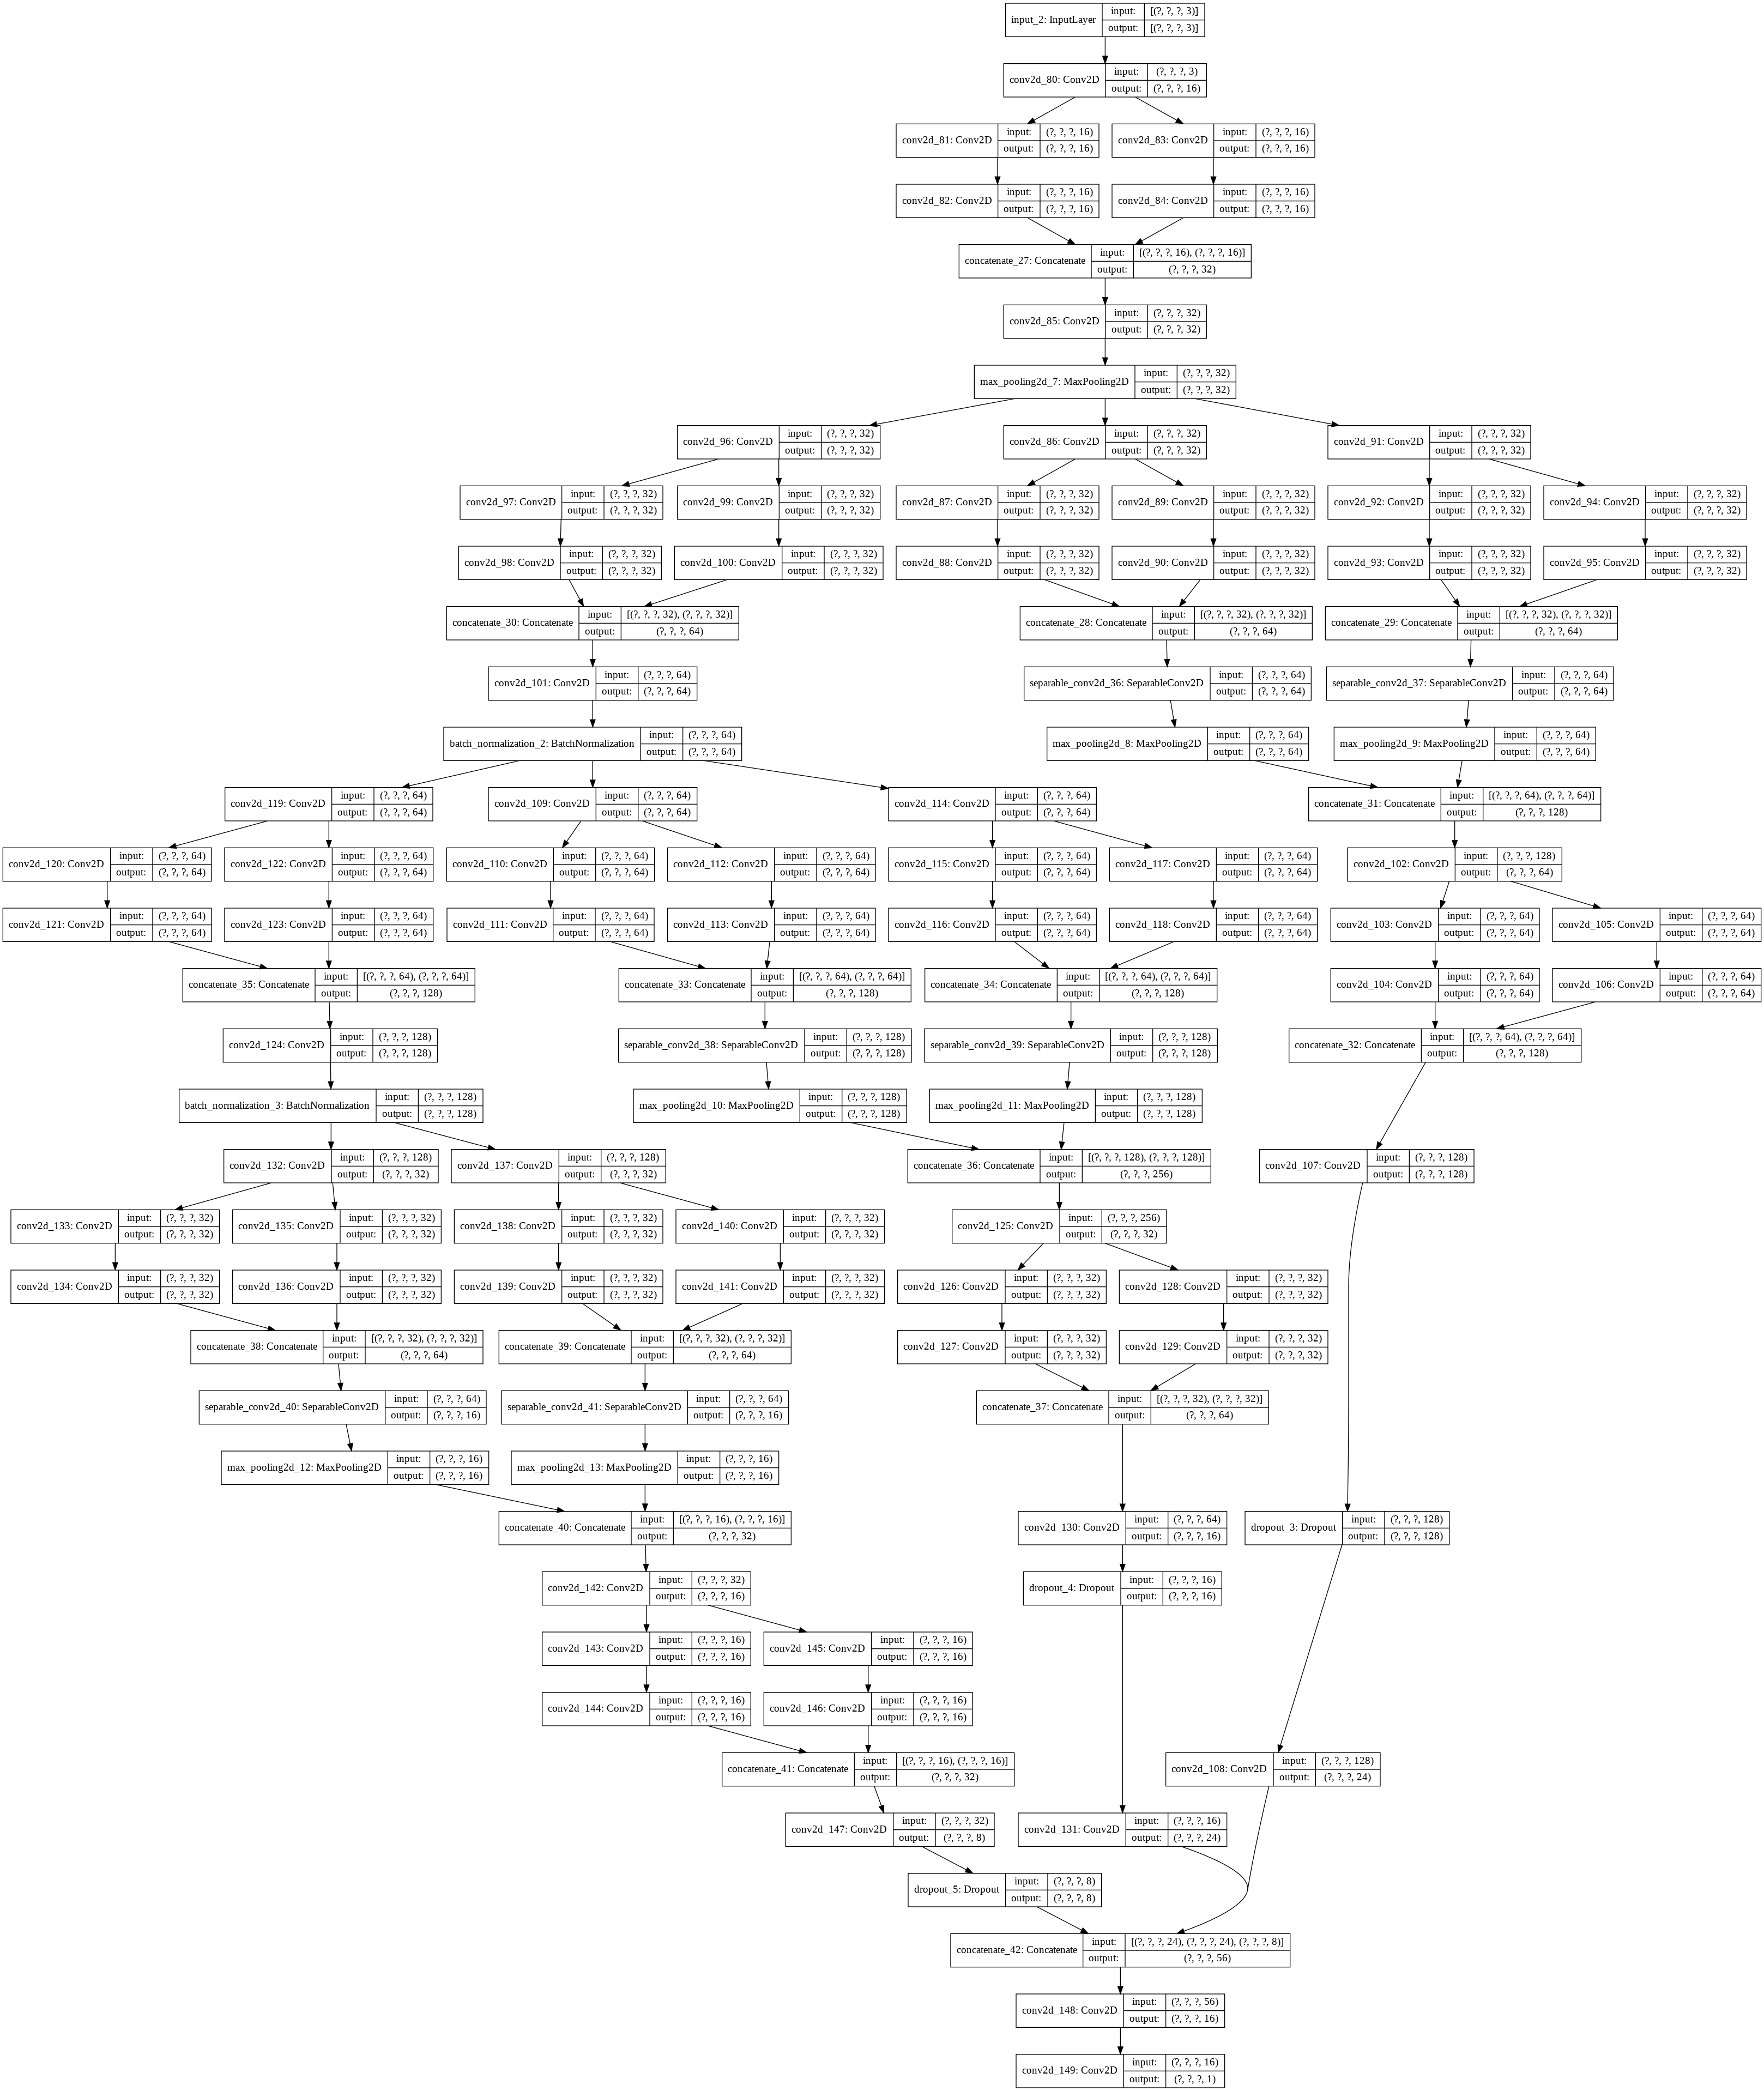

In [0]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [0]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d_80 (Conv2D)              (None, None, None, 1 448         input_2[0][0]                    
__________________________________________________________________________________________________
conv2d_81 (Conv2D)              (None, None, None, 1 784         conv2d_80[0][0]                  
__________________________________________________________________________________________________
conv2d_83 (Conv2D)              (None, None, None, 1 784         conv2d_80[0][0]                  
____________________________________________________________________________________________

In [0]:
sgd = tf.keras.optimizers.SGD(lr = 1e-7, decay = (5*1e-4), momentum = 0.95)
model.compile(optimizer=sgd, loss=tf.keras.losses.MeanSquaredError(), metrics=['mse', 'mae', 'accuracy'])

In [0]:
def save_mod(model , str1 , str2):
    model.save_weights(str1)
    
    model_json = model.to_json()
    
    with open(str2, "w") as json_file:
        json_file.write(model_json)

In [0]:
model_history1 = model.fit(train_gen, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, validation_data=test_gen, verbose=1)
save_mod(model,"model_A_weights1.h5","Model1.json")
files.download("model_A_weights1.h5")
files.download("Model1.json")
model_history2 = model.fit(train_gen, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, validation_data=test_gen, verbose=1)
save_mod(model,"model_A_weights2.h5","Model2.json")
files.download("model_A_weights2.h5")
files.download("Model2.json")
model_history3 = model.fit(train_gen, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, validation_data=test_gen, verbose=1)
save_mod(model,"model_A_weights3.h5","Model3.json")
files.download("model_A_weights3.h5")
files.download("Model3.json")
model_history4 = model.fit(train_gen, epochs=EPOCHS, steps_per_epoch=STEPS_PER_EPOCH, validation_steps=VALIDATION_STEPS, validation_data=test_gen, verbose=1)
save_mod(model,"model_A_weights4.h5","Model4.json")
files.download("model_A_weights4.h5")
files.download("Model4.json")

  ...
    to  
  ['...']


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:20: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.


  ...
    to  
  ['...']
Train for 150 steps, validate for 45 steps
Epoch 1/50
150/150 [==============================] - 364s 2s/step - loss: 0.0050 - mse: 0.0041 - mae: 0.0428 - accuracy: 0.1839 - val_loss: 0.0020 - val_mse: 0.0016 - val_mae: 0.0171 - val_accuracy: 0.2078
Epoch 2/50
150/150 [==============================] - 245s 2s/step - loss: 0.0056 - mse: 0.0051 - mae: 0.0432 - accuracy: 0.2102 - val_loss: 0.0022 - val_mse: 0.0021 - val_mae: 0.0200 - val_accuracy: 0.2071
Epoch 3/50
150/150 [==============================] - 186s 1s/step - loss: 0.0056 - mse: 0.0046 - mae: 0.0419 - accuracy: 0.2593 - val_loss: 0.0033 - val_mse: 0.0028 - val_mae: 0.0278 - val_accuracy: 0.1329
Epoch 4/50
150/150 [==============================] - 157s 1s/step - loss: 0.0059 - mse: 0.0052 - mae: 0.0435 - accuracy: 0.2374 - val_loss: 0.0024 - val_mse: 0.0020 - val_mae: 0.0307 - val_accuracy: 0.2295
Epoch 5/50
150/150 [==============================] - 165s 1s/step - loss: 0.0067 - mse: 0.0062 - mae: 0

KeyboardInterrupt: ignored

In [0]:
import matplotlib.pyplot as plt

loss = model_history4.history['loss']
val_loss = model_history4.history['val_loss']

epochs = range(EPOCHS)

plt.figure()
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 0.005])
plt.legend()
plt.show()

In [0]:
def load_model():
    # Function to load and return neural network model 
    json_file = open('Model1.json', 'r')
    loaded_model_json = json_file.read()
    json_file.close()
    loaded_model = tf.keras.models.model_from_json(loaded_model_json)
    loaded_model.load_weights("model_A_weights1.h5")
    return loaded_model

def create_img_test(path):
    #Function to load,normalize and return image 
    print(path)
    im = Image.open(path).convert('RGB')
    
    im = np.array(im)
    
    im = im/255.0
    
    im[:,:,0]=(im[:,:,0]-0.485)/0.229
    im[:,:,1]=(im[:,:,1]-0.456)/0.224
    im[:,:,2]=(im[:,:,2]-0.406)/0.225


    im = np.expand_dims(im,axis  = 0)
    return im
def predict(path):
    loaded_model = load_model()
    image = create_img_test(path)
    ans = model.predict(image)
    count = np.sum(ans)
    return count,image,ans

In [0]:
#testing on specific images
ans,img,hmap = predict('/content/part_A_final/test_data/images/IMG_10.jpg')
print(ans)
#Print count, image, heat map
plt.imshow(img.reshape(img.shape[1],img.shape[2],img.shape[3]))
plt.show()
plt.imshow(hmap.reshape(hmap.shape[1],hmap.shape[2]) , cmap = c.jet )
plt.show()

Original Count :  904
900.66626


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: DeprecationWarning: Both axis > a.ndim and axis < -a.ndim - 1 are deprecated and will raise an AxisError in the future.
  


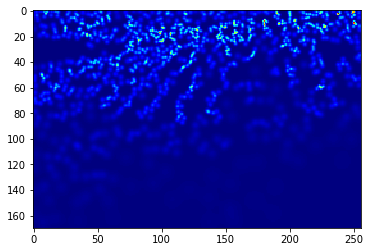

In [0]:
temp = h5py.File('/content/drive/My Drive/ShanghaiTech_h5/part_A_final/train_data/ground/IMG_10.h5' , 'r')
temp_1 = np.asarray(temp['density'])
print("Original Count : ",int(np.sum(temp_1)))
img = cv2.resize(temp_1,(int(temp_1.shape[1]/4),int(temp_1.shape[0]/4)),interpolation = cv2.INTER_CUBIC)*16
plt.imshow(img,cmap = c.jet)
img = np.expand_dims(img,axis  = 3)
print(np.sum(img))

In [0]:
loaded_model = load_model()
Y_pred = []
Y_test = []
for test_path in test_paths:
  im = create_img_test(test_path)
  Y_pred.append(np.sum(model.predict(im)))
  ground_truth_path = os.path.join('/content/drive/My Drive/ShanghaiTech_h5', test_path.replace('.jpg','.h5').replace('images','ground'))
  temp = h5py.File(ground_truth_path, 'r')
  Y_test.append(np.sum(np.asarray(temp['density'])))

In [0]:
mae = mean_absolute_error(Y_test, Y_pred)
rmse = mean_squared_error(Y_test, Y_pred)
print("MAE =", mae)
print("MSE =", mse)